# A Bayesian network to predict whether enough tables will be booked in a restaurant

## Students who participated in the project: 

**Brescia Davide** - 0001036867 - davide.brescia@studio.unibo.it

**Zorila Iulian** - 0001033291 - iulian.zorila@studio.unibo.it

## Introduction

The goal of this project is to find out the *probability of getting table reservations that will lead to a sufficient profit*. Several simplifications have been considered, we are talking for example about any restaurant located in a city, where it is generally sunny, very visited in 3 months of the year. The restaurant will also be able to host theme parties, special guests and shows, and will be able to change the cost of the meal.

In this Bayesian network, **11 nodes** divided into two macro categories were used: **internal factors** and **external factors**. Internal factors are factors that depend on the restaurant manager (such as price or any special nights) while external factors do not depend on the restaurant manager (such as weather or calendar day).

*The Bayesian network including cpt is reported below.*

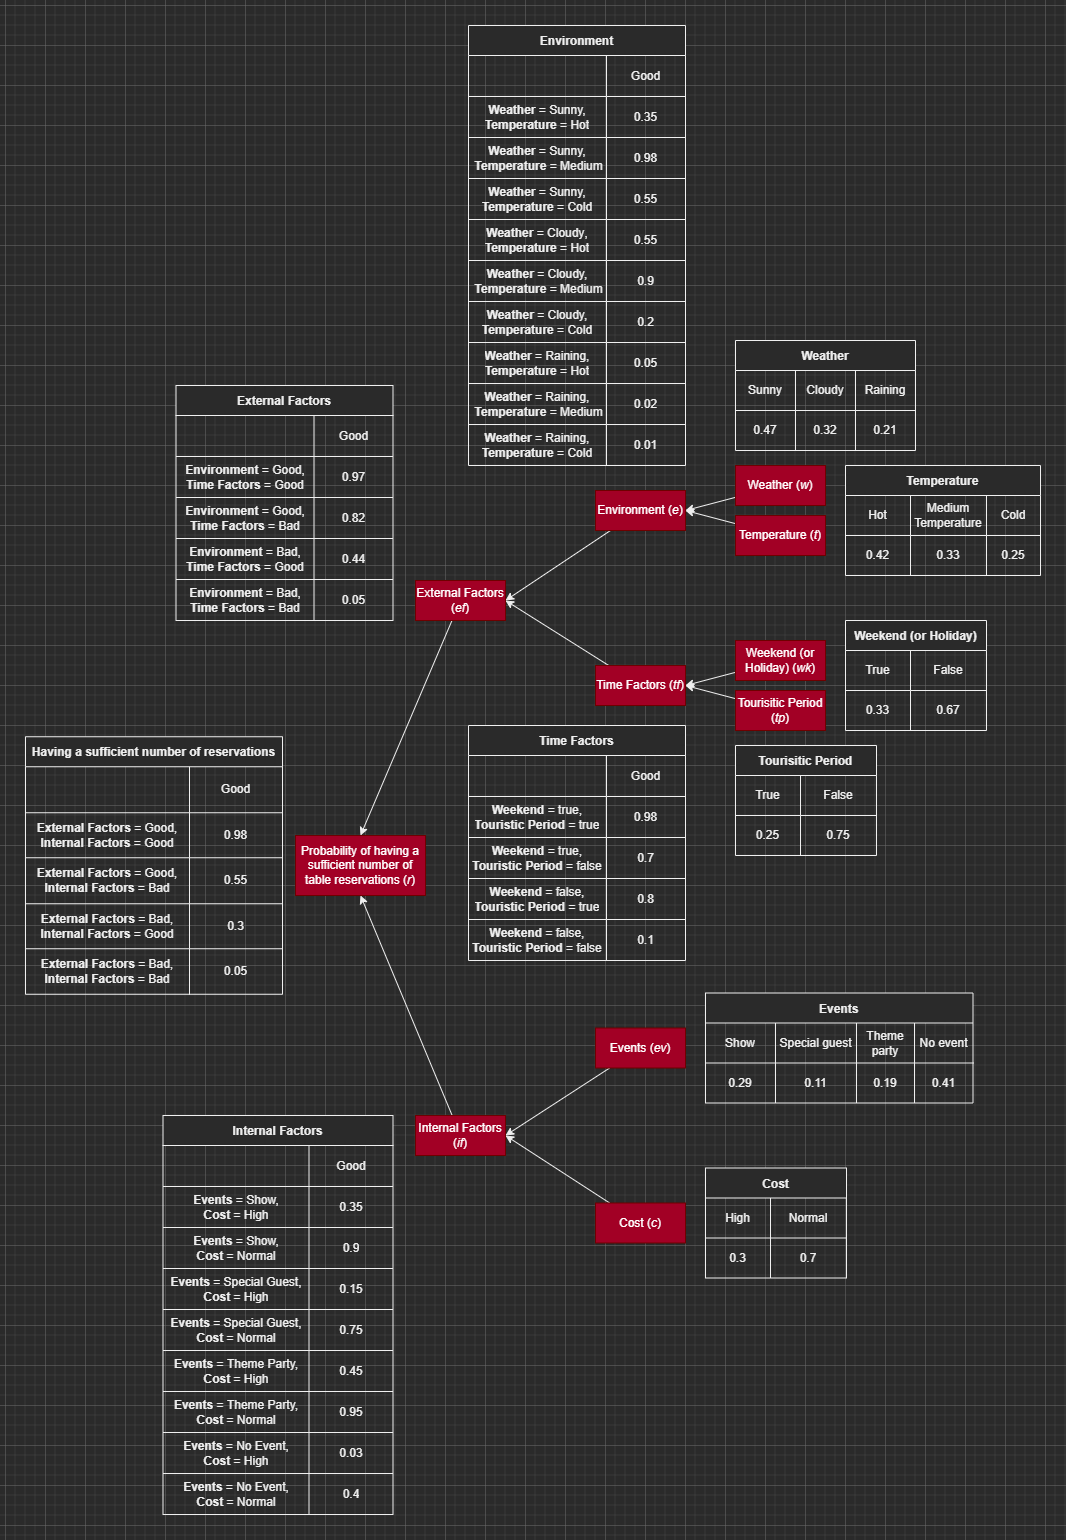

We can rewrite our network using a matematical formula and applaying the chain rule and the conditional probability we obtain this compact representation:

$$P(r, if, ef, e, tf, ev, c, w, t, wk, tp) = P(r|if, ef) P(if|c, ev) P(ef|tf,e) P(e|w, t)P(tf|wk, tp)P(c)P(ev)P(w)P(t)P(wk)P(tp)$$

4+8+4+9+4+1+3+2+2+1+1 = 39 independent values

## Bayesian Network Code

In [ ]:
!pip install pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.models import MarkovChain as MC
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [ ]:
model = BayesianNetwork([('InternalFactors','Reservations'), ('ExternalFactors','Reservations'),
                         ('TimeFactors','ExternalFactors'),('Environment','ExternalFactors'),('Weather','Environment'),
                         ('Temperature','Environment'),('Events','InternalFactors'), ('Cost','InternalFactors'),
                         ('Weekend','TimeFactors'),('TouristicPeriod','TimeFactors')])

# Defining individual CPDs.

# Weather // https://en.climate-data.org/europe/italy/emilia-romagna/bologna-5093/
cpd_w = TabularCPD(variable='Weather', variable_card=3, values=[[0.47], [0.32], [0.21]], state_names={'Weather': ['Sunny', 'Cloudy', 'Raining']}) 

# Temperature // https://en.climate-data.org/europe/italy/emilia-romagna/bologna-5093/
cpd_t = TabularCPD(variable='Temperature', variable_card=3, values=[[0.42], [0.33], [0.25]], state_names={'Temperature': ['Hot', 'Medium Temperature', 'Cold']})

# Weekend
cpd_wk = TabularCPD(variable='Weekend', variable_card=2, values=[[0.33],[0.67]], state_names={'Weekend': ['Yes', 'No']})

# Touristic period
cpd_tp = TabularCPD(variable='TouristicPeriod', variable_card=2, values=[[0.25],[0.75]], state_names={'TouristicPeriod': ['Yes', 'No']})

# Events
cpd_ev = TabularCPD(variable='Events', variable_card=4, values=[[0.29],[0.11],[0.19],[0.41]], state_names={'Events': ['Show', 'SpecialGuest','ThemeParty','NoEvent']})

# Cost
cpd_c = TabularCPD(variable='Cost', variable_card=2, values=[[0.3],[0.7]], state_names={'Cost': ['High', 'Normal']})

# Environment
cpd_e = TabularCPD(variable='Environment', variable_card=2,
                   values=[[0.35, 0.98, 0.55, 0.55, 0.9, 0.2, 0.05, 0.02, 0.01],
                           [0.65, 0.02, 0.45, 0.45, 0.1, 0.8, 0.95, 0.98, 0.99]],
                   state_names={'Environment': ['Good', 'Bad'],
                                'Weather': ['Sunny', 'Cloudy', 'Raining'],
                                'Temperature': ['Hot', 'Medium Temperature', 'Cold']},
                   evidence=['Weather', 'Temperature'],
                   evidence_card=[3, 3])

# Time factors
cpd_tf = TabularCPD(variable='TimeFactors', variable_card=2,
                   values=[[0.98, 0.7, 0.8, 0.1],
                           [0.02, 0.3, 0.2, 0.9]],
                   state_names={'TimeFactors': ['Good', 'Bad'],
                                'Weekend': ['Yes', 'No'],
                                'TouristicPeriod': ['Yes', 'No']},
                   evidence=['Weekend','TouristicPeriod'],
                   evidence_card=[2,2])

# External factors
cpd_ef = TabularCPD(variable='ExternalFactors', variable_card=2,
                   values=[[0.97, 0.82, 0.44,  0.05],
                           [0.03, 0.18, 0.56,  0.95]],
                   state_names={'ExternalFactors': ['Good', 'Bad'],
                                'Environment': ['Good', 'Bad'],
                                'TimeFactors': ['Good', 'Bad']},
                   evidence=['Environment','TimeFactors'],
                   evidence_card=[2,2])

# Internal factors
cpd_if = TabularCPD(variable='InternalFactors', variable_card=2,
                   values=[[0.35, 0.9, 0.15, 0.75, 0.45, 0.95, 0.03, 0.4],
                           [0.65, 0.1, 0.85, 0.25, 0.55, 0.05, 0.97, 0.6]],
                   state_names={'InternalFactors': ['Good', 'Bad'],
                                'Events': ['Show', 'SpecialGuest','ThemeParty','NoEvent'],
                                'Cost': ['High', 'Normal']},
                   evidence=['Events','Cost'],
                   evidence_card=[4,2])

# Reservations
cpd_r = TabularCPD(variable='Reservations', variable_card=2,
                   values=[[0.98, 0.55, 0.3, 0.05],
                           [0.02, 0.45, 0.7, 0.95]],
                   state_names={'Reservations': ['Yes', 'No'],
                                'ExternalFactors': ['Good', 'Bad'],
                                'InternalFactors': ['Good', 'Bad']},
                   evidence=['ExternalFactors','InternalFactors'],
                   evidence_card=[2,2])

# Associating the CPDs with the network
model.add_cpds(cpd_w, cpd_t, cpd_wk, cpd_tp, cpd_ev, cpd_c,
               cpd_e, cpd_ef, cpd_tf, cpd_if, cpd_r)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

True

### Indipendence



####Active trails
A trail is said to be active between two nodes if allows influence to flow between them. Moreover influence can proceed through nodes in different ways:

*   Direct cause  &emsp;&emsp;&nbsp; $X → Y$ 
*   Direct effect &emsp;&emsp;&nbsp; $X ← Y$
*   Causal trail  &emsp;&emsp;&ensp;&nbsp; $X → Z → Y$ ($Z\notin Evidence$)
*   Evidential trail &emsp;&ensp; $X ← Z ← Y$ ($Z\notin Evidence$)
*   Common effect &emsp;$X ← Z → Y$ ($Z\notin Evidence$)
*   Common cause &emsp;$X → Z ← Y$ ($Z\in Evidence$)

This is useful to check whether a variable is indipendent of another, given an eventual evidence.

In [ ]:
# Draw the network and color differenlty nodes belonging to the active trail
def draw_active_trail(target_node, evidence = None, title = None, default_color = '#CC5500', active_color = '#006400'):
  active_trail = model.active_trail_nodes(target_node, observed=evidence)

  # Set colors
  nodes = list(model.nodes())
  colors = [default_color for _ in nodes]

  for n in active_trail[target_node]:
    i = nodes.index(n)
    colors[i] = active_color

  # Set position and eventual options
  pos={"Weather":(0,5),"Temperature":(0,4),"Weekend":(0,3),"TouristicPeriod":(0,2),"Cost":(0,1),"Events":(0,0),
     "Environment":(-1,4.5), "TimeFactors":(-1,2.5),
     "ExternalFactors":(-2,3.5),"InternalFactors":(-2,0.5),
     "Reservations":(-3,2.75)}

  options = {
      'node_color': colors,
      'node_size': 3500,
      'width': 2,
      'node_size': 4500,
      'font_color': 'white'
  }

  fig=plt.figure(figsize=(9,8))
  plt.title(title)
  nx.draw(model, pos=pos, font_size=9, with_labels=True, **options)
  plt.show()
  print(f'\nNodes connected to {target_node} through: {active_trail[target_node]}\n')

# Prints the Markov Blanket for each node
def all_mb():
  print('Markov blanket for each node:\n')
  longest_len = len(max(model.nodes(), key=len))
  for n in model.nodes():
    spaces = ' '*(longest_len - len(n))
    print(f'{n}:{spaces}\t {model.get_markov_blanket(n)}')

####Let's see some examples of indipendence
We want to check if **Weather** is indipendent of **TouristicPeriod**, without considering any evidence at the moment

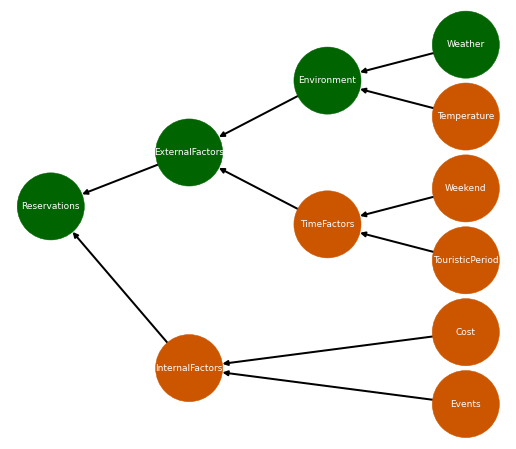


Nodes connected to Weather through: {'Reservations', 'ExternalFactors', 'Environment', 'Weather'}

Indipendency: (Weather ⟂ InternalFactors, TimeFactors, Temperature, Weekend, Cost, TouristicPeriod, Events)


In [ ]:
draw_active_trail(target_node='Weather')
print(f'Indipendency: {model.local_independencies("Weather")}')

In the above example, clearly, **Weather** does not influence in any way **TouristicPeriod** and therefore they are indipendent.

Now, if we simply add **ExternalFactors** to the evidence, this will activate the V-structure, allowing for influence to flow and consequently create a dipendent relationship between **Weather** and **TouristicPeriod**

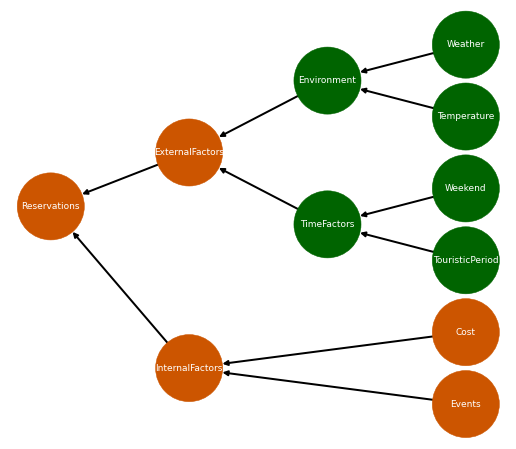


Nodes connected to Weather through: {'TimeFactors', 'Environment', 'Temperature', 'Weekend', 'TouristicPeriod', 'Weather'}



In [ ]:
draw_active_trail(target_node='Weather', evidence=['ExternalFactors'])

Another example of indipendence can be shown with **ExternalFactors**. Let's try to observe its parents and look at the result.

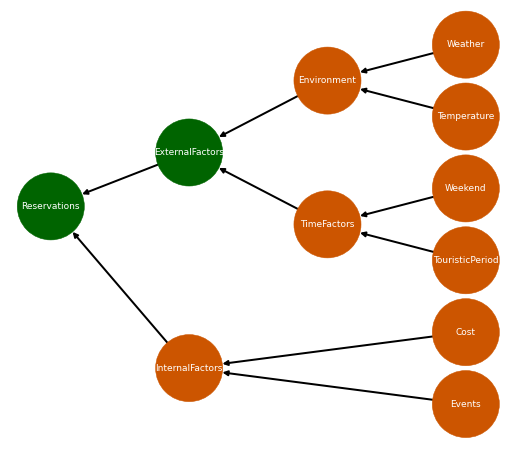


Nodes connected to ExternalFactors through: {'Reservations', 'ExternalFactors'}

Indipendency: (ExternalFactors ⟂ InternalFactors, Weather, Temperature, Weekend, Cost, TouristicPeriod, Events | TimeFactors, Environment)


In [ ]:
draw_active_trail(target_node='ExternalFactors', evidence=['Environment','TimeFactors'])
print(f'Indipendency: {model.local_independencies("ExternalFactors")}')

As we can see from the graph above, **ExternalFactors** is indipendent of all its nondescendats given its parents

####Markov Blanket
For a given node, is defined by its parents, its children and the childrens' parents. Hence, a node is indipendent of all the others, given its Markov Blanket.

Let us see an example with **ExternalFactors**.

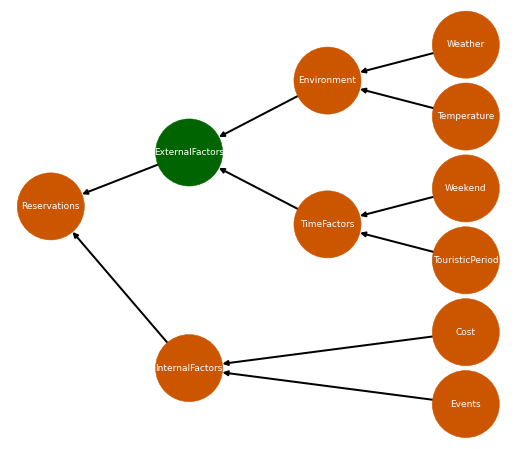


Nodes connected to ExternalFactors through: {'ExternalFactors'}

Markov Blanket of ExternalFactors ['TimeFactors', 'Environment', 'Reservations', 'InternalFactors']


In [ ]:
mb = model.get_markov_blanket('ExternalFactors')
draw_active_trail(target_node='ExternalFactors',evidence=mb)
print(f'Markov Blanket of ExternalFactors {mb}')

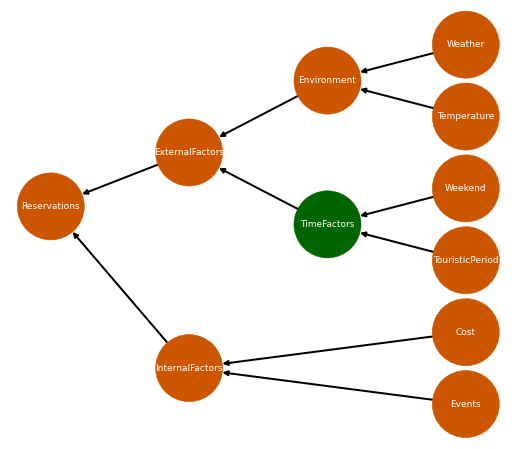


Nodes connected to TimeFactors through: {'TimeFactors'}

Markov Blanket of TimeFactors ['Environment', 'Weekend', 'ExternalFactors', 'TouristicPeriod']


In [ ]:
mb = model.get_markov_blanket('TimeFactors')
draw_active_trail(target_node='TimeFactors',evidence=mb)
print(f'Markov Blanket of TimeFactors {mb}')

## Inferences

Bayesian networks are a type of probabilistic graphical model that uses Bayesian inference for probability computations. More specifically, these networks, aim to model conditional dependence, and therefore causation, by representing conditional dependence by edges in a directed graph.

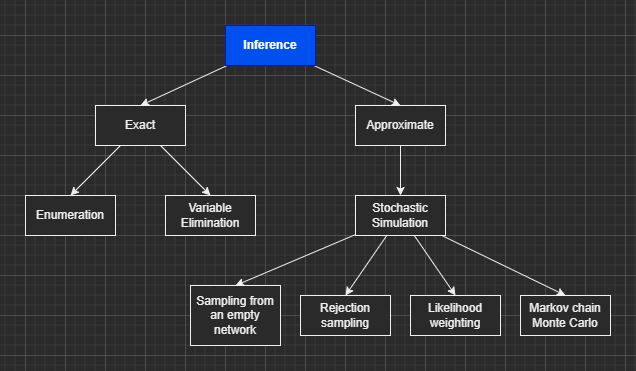

### Exact Inference

#### Differences Between Variable Enumeration and Variable Elimination

Let's consider this probability here:

$$P(R | Ev = show,\ W = sunny)$$

Calculate this probability here using **Variable Enumeration**, even considering a small amount of nodes, is really expensive. We can verify this appying summation:

$$P(R | Ev=show,\  W = sunny) = \alpha\sum_{ef,\  e,\ tf,\ t,\ wk,\ tp,\ if,\ c}P(R,\  ef,\  if,\ e,\ tf,\ W=sunny,\ t,\ wk,\ tp,\ Ev=show,\ c)$$

And then applying Global Semantics we obtain

$$\alpha \sum_{ef,\  e,\ tf,\ t,\ wk,\ tp,\ if,\ c}P(R|ef,\ if)P(ef|e,\ tf)P(e|W=sunny,\ t)P(W=sunny)P(t)P(tf|wk,\ tp)P(wk)P(tp)P(if|Ev=show,\ c)P(Ev=show)P(c)$$

We can rewrite the previous equation without using the summation and we come up with something like this:

*P(R|EF = good, IF = good)P(EF = good|E = good, TF = good)P(E = good|**W = sunny**, T = hot)P(**W = sunny**)P(T = hot)P(TF = good|WK = true, TP = true)P(WK = true)P(TP = true)P(IF = good|**Ev = show**, C = medium)P(**Ev = show**)P(C = medium) +* 

*P(R|EF = good, IF = good)P(EF = good|E = good, TF = good)P(E = good|**W = sunny**, T = hot)P(**W = sunny**)P(T = hot)P(TF = good|WK = true, TP = true)P(WK = true)P(TP = true)P(IF = good|**Ev = show**, C = high)P(**Ev = show**)P(C = high) +*

*P(R|EF = good, IF = good)P(EF = good|E = good, TF = good)P(E = good|**W = sunny**, T = hot)P(**W = sunny**)P(T = hot)P(TF = good|WK = true, TP = true)P(WK = true)P(TP = true)P(IF = bad|**Ev = show**,\ C = medium)P(**Ev = show**)P(C = medium)*

**+ ... +**

*P(R|EF = bad, IF = bad)P(EF = bad|E = bad, TF = bad)P(E = bad|**W = sunny**, T = cold)P(**W = sunny**)P(T = cold)P(TF = bad|WK = false, TP = false)P(WK = false)P(TP = false)P(IF = bad|**Ev = show**, C = high)P(**Ev = show**)P(C = high)*

In total we have 384 sums among which many of them are repeated, overall this approach is very **expensive computationally**.

\\

---

\\

Let's consider for the same query **Variable Elimination**.

$$P(R | Ev = show,\ W = sunny)$$

We start using the same equation:

$$P(R | Ev=show,\  W = sunny) = \alpha \sum_{ef,\  e,\ tf,\ t,\ wk,\ tp,\ if,\ c}P(R|ef,\ if)P(ef|e,\ tf)P(e|W=sunny,\ t)P(W=sunny)P(t)P(tf|wk,\ tp)P(wk)P(tp)P(if|Ev=show,\ c)P(Ev=show)P(c)$$

Then we obtain:

$$P(R | Ev=show,\  W = sunny) = \alpha \sum_{ef,\  if}P(R|ef,\ if)\sum_{e,\ tf}P(ef|e,\ tf)\sum_{t}P(e|W=sunny,\ t)P(W=sunny)P(t)\sum_{wk,\ tp}P(tf|wk,\ tp)P(wk)P(tp)\sum_{c}P(if|Ev=show,\ c)P(Ev=show)P(c)$$

Iteratively, we group all factors that depend on a given hidden variable, multiply them together, and sum out. We do that in turn for each relevant hidden variable.

$$f_{\bar C,\ IF}(if, c) = \sum_{c}P(if|Ev=show,\ c)P(Ev=show)P(c)\ =\  <0.35\times 1\times 0.3 + 0.9\times 1\times 0.7, 0.65\times 1 \times 0.3 + 0.1\times 1 \times 0.7>\ =\ <0.735,\ 0.265>$$

Let's substitute this result:

$$P(R | Ev=show,\  W = sunny) = \alpha \sum_{ef,\  if}P(R|ef,\ if)\sum_{e,\ tf}P(ef|e,\ tf)\sum_{t}P(e|W=sunny,\ t)P(W=sunny)P(t)\sum_{wk,\ tp}P(tf|wk,\ tp)P(wk)P(tp)f_{\bar C,\ IF}(if, c)$$

Then we consider:

$$f_{\bar WK,\ \bar TP,\ TF}(tf, wk, tp) = \sum_{wk,\ tp}P(tf|wk,\ tp)P(wk)P(tp) \ = \ <0.98 \times 0.33 \times 0.25 + 0.7 \times 0.33 \times 0.75 + 0.8 \times 0.67 \times 0.25 + 0.1 \times 0.67 \times 0.75,\ 0.02 \times 0.33 \times 0.25 + 0.3 \times 0.33 \times 0.75 + 0.2 \times 0.67 \times 0.25 + 0.9 \times 0.67 \times 0.75>\ = \ <0.43835,\ 0.56165>$$

Let's substitute this result:

$$P(R | Ev=show,\  W = sunny) = \alpha \sum_{ef,\  if}P(R|ef,\ if)\sum_{e,\ tf}P(ef|e,\ tf)\sum_{t}P(e|W=sunny,\ t)P(W=sunny)P(t)f_{\bar WK,\ \bar TP,\ TF}(tf, wk, tp)f_{\bar C,\ IF}(if, c)$$

Then we consider:

$$f_{\bar T,\ E}(e, t) = \sum_{t}P(e|W=sunny,\ t)P(W=sunny)P(t) \ = \ <0.35 \times 0.42 + 0.98\times 0.33 + 0.55 \times 0.25,\ 0.65 \times 0.42 + 0.02\times 0.33 + 0.45 \times 0.25>\ = \ <0.6079, 0.3921>$$

Let's substitute this result:

$$P(R | Ev=show,\  W = sunny) = \alpha \sum_{ef,\  if}P(R|ef,\ if)\sum_{e,\ tf}P(ef|e,\ tf)f_{\bar T,\ E}(e, t)f_{\bar WK,\ \bar TP,\ TF}(tf, wk, tp)f_{\bar C,\ IF}(if, c)$$

Then we consider:

$$f_{\bar TF,\bar E,\ EF}(ef, tf, e) = \sum_{e,\ tf}P(ef|e,\ tf)f_{\bar T,\ E}(e, t)f_{\bar WK,\ \bar TP,\ TF}(tf, wk, tp) = <0.97\times 0.43835\times 0.6079 + 0.82\times 0.56165 \times 0.6079 + 0.44 \times 0.43835 \times 0.3921 + 0.05 \times 0.56165 \times 0.3921, 0.03\times 0.43835\times 0.6079 + 0.18\times 0.56165 \times 0.6079 + 0.56 \times 0.43835 \times 0.3921 + 0.95 \times 0.56165 \times 0.3921>\ = \  <0.625085988,\ 0.374914012>$$

Finally we obtain:

$$P(R | Ev=show,\  W = sunny) = \sum_{ef,\  if}P(R|ef,\ if)f_{\bar TF,\bar E,\ EF}(ef, tf, e)f_{\bar C,\ IF}(if, c) = \alpha <0.98 \times 0.625085988 \times 0.735 + 0.55 \times 0.625085988 \times 0.265 + 0.3 \times 0.374914012 \times 0.735 + 0.05 \times 0.374914012 \times 0.265, 0.98 \times 0.625085988 \times 0.735 + 0.45 \times 0.625085988 \times 0.265 + 0.7 \times 0.374914012 \times 0.735 + 0.95 \times 0.374914012 \times 0.265>\ = \ <0.62899187,\ 0.37100813>$$

So:

$$P(R | Ev=show,\  W = sunny) =\  <0.62899187,\ 0.37100813>$$



In [ ]:
infer_ve = VariableElimination(model)
q_0 = infer_ve.query(['Reservations'],{'Weather':'Sunny', 'Events':'Show'}, show_progress=False)
print(f'Query: P(R|E = Show, W = Sunny)\n{q_0}')

Query: P(R|E = Show, W = Sunny)
+-------------------+---------------------+
| Reservations      |   phi(Reservations) |
+===================+=====================+
| Reservations(Yes) |              0.6290 |
+-------------------+---------------------+
| Reservations(No)  |              0.3710 |
+-------------------+---------------------+


#### Queries with Variable Elimination


##### All nodes are unknown

> **P(Reservations)**

Considering all unknown node values, the result we get from the Bayesian network is approximately 50-50. This means that generally, without having any data available, the venue has a probability of getting sufficient bookings of about 50%.

In [ ]:
q_1 = infer_ve.query(['Reservations'], show_progress=False)
print(f'Query: P(R)\n{q_1}')

Query: P(R)
+-------------------+---------------------+
| Reservations      |   phi(Reservations) |
+===================+=====================+
| Reservations(Yes) |              0.5085 |
+-------------------+---------------------+
| Reservations(No)  |              0.4915 |
+-------------------+---------------------+


##### We are in a weekend day

> **P(Reservations|Weekend=Yes)**

Simply telling the system that we are on a weekend day (or any holiday) will result in an improvement in the final probability. In particular the increase from the probability without evidence is 5.5%.


In [ ]:
q_2 = infer_ve.query(['Reservations'],{'Weekend':'Yes'}, show_progress=False)
print(f'Query: P(R|WK=Yes)\n{q_2}')

Query: P(R|WK=Yes)
+-------------------+---------------------+
| Reservations      |   phi(Reservations) |
+===================+=====================+
| Reservations(Yes) |              0.5632 |
+-------------------+---------------------+
| Reservations(No)  |              0.4368 |
+-------------------+---------------------+


##### There is a special guest but is raining

> **P(Reservations|Events = Special Guest, Weather = Raining)**.

In the following case, we add positive evidence (the presence of a special guest) and negative evidence (rain). As we can see from the distribution though, the probability of getting enough bookings is remarkably low.

In [ ]:
q_3 = infer_ve.query(['Reservations'],{'Events':'SpecialGuest', 'Weather':'Raining'}, show_progress=False)
print(f'Query: P(R|EV = Special Guest, W = Raining)\n{q_3}')

Query: P(R|EV = Special Guest, W = Raining)
+-------------------+---------------------+
| Reservations      |   phi(Reservations) |
+===================+=====================+
| Reservations(Yes) |              0.3377 |
+-------------------+---------------------+
| Reservations(No)  |              0.6623 |
+-------------------+---------------------+


##### Predict the Internal Factor if we raise the price

> **P(InternalFactors|Cost = High)**.

In this case, we want to get information only about the internal factor if we wanted to implement a price increase. As we can see probability of having good internal factors decreases substantially. A possible solution in order to increase the probability to have good internal factors would be that one to organize an event.

In [ ]:
q_4 = infer_ve.query(['InternalFactors'],{'Cost':'High'}, show_progress=False)
print(f'Query: P(IF|C = High)\n{q_4}')

Query: P(IF|C = High)
+-----------------------+------------------------+
| InternalFactors       |   phi(InternalFactors) |
+=======================+========================+
| InternalFactors(Good) |                 0.2158 |
+-----------------------+------------------------+
| InternalFactors(Bad)  |                 0.7842 |
+-----------------------+------------------------+


##### Evidential reasoning example

> **P(TouristicPeriod|Reservations=Yes)**

We can also try to apply evidential reasoning, we can then predict, starting from the fact that we had a good amount of bookings and we want to know what is the probability that day was a tourist month. 

As bad as this may seem, it is important to note that the probability of being in a tourist month is 0.25 (3/12 months). So, as expected, there was an increase in the probability of being in a tourist month.


In [ ]:
q_5 = infer_ve.query(['TouristicPeriod'],{'Reservations':'Yes'}, show_progress=False)
print(f'Query: P(TP|R=Yes)\n{q_5}')

Query: P(TP|R=Yes)
+----------------------+------------------------+
| TouristicPeriod      |   phi(TouristicPeriod) |
+======================+========================+
| TouristicPeriod(Yes) |                 0.2841 |
+----------------------+------------------------+
| TouristicPeriod(No)  |                 0.7159 |
+----------------------+------------------------+


### **Approximate Inference**




####Sampling from an empty network: 
Starting from a random sequence of samples, we extract a new one for each node of the network in a topological order to estimate its value, according to a uniform distribution between 0 and 1. 

This process is repetead until we've exhausted all the samples.

Lastly, the original query is approximated computing the ratio between the number of samples in which the event is true and the total number of samples.<br><br>

####Rejection Sampling
It follows the same idea of the previous method, with the addition of rejection.

Hence, everything which does not agree with the evidence is thrown away.

The approximated distribution then is computed by the number of samples in which the event is true over the total number of samples which agree with the evidence. <br><br>

####Likelihood weighting 
Compared to rejection sampling avoids its inefficiency by generating only events that are consistent with the evidence. 

Fixes the values for the evidence variables and samples only the nonevidence variables. This guarantees that each event generated is consistent with the evidence.


In [ ]:
# Constants
LW = 'LikelihoodWeighting'
RS = 'RejectionSampling'
VE = 'VariableElimination'
SZ = 'SampleSize'
SEED = 50

inference = BayesianModelSampling(model)

# Compute proabilities, given the samples, variable and its respective value
def probs(evidence, sample_size, variable, value):

  # Likelihood weighting
  start = time.time()
  samples_lw = inference.likelihood_weighted_sample(evidence=evidence, size=sample_size, seed=SEED, show_progress=False)
  end = time.time()
  lw_time = end - start

  mask = samples_lw[variable] == value
  prob_lw = np.round(samples_lw['_weight'][mask].sum() / samples_lw['_weight'].sum(), 4)

  # Rejection sampling
  start = time.time()
  samples_rs = inference.rejection_sample(evidence=evidence, size=sample_size, seed=SEED, show_progress=False)
  end = time.time()
  rs_time = end - start

  prob_rs = (samples_rs[variable] == value).sum() / samples_rs[variable].count()

  # Results
  probabilities = pd.DataFrame([[len(samples_rs), prob_rs, prob_lw]], columns=[SZ,RS,LW])
  elapsed_time = pd.DataFrame([[rs_time, lw_time]], columns=['RS_Time','LW_Time'])

  return (probabilities, elapsed_time)

# Plot the probabilities in function of the total number of samples
def plot_results(values, elapsed_time, title):
  
  # Separate samples column from probabilities values
  probabilities = values.iloc[:,1:] 
  total_samples = values[SZ]

  plt.style.use('ggplot')
  fig, ax = plt.subplots(1, 3, figsize=(20,7))

  fig.suptitle(title)
  
  ax[0].set_ylim(0, 1)
  ax[0].set_title('Probabilities')

  ax[1].set_ylim(0, 0.5)
  ax[1].set_title('Elapsed time from 0s to 0.5s')

  ax[2].set_title(f'Elapsed time from 0s to {np.round(elapsed_time.max().max(),2)}s')

  for (column_name, column_data) in probabilities.iteritems():
    ax[0].semilogx(total_samples, column_data.values, label=column_name)

  for (column_name, column_data) in elapsed_time.iteritems():
    ax[1].semilogx(total_samples, column_data.values, label=column_name)
    ax[2].semilogx(total_samples, column_data.values, label=column_name)
  
  ax[0].legend(loc="lower right")
  plt.show()

####Run multiple experiments
With an increasing number of samples to compare **Rejection Sampling** and **Likelihood Weighting** with exact inference, to see how much will it take to converge to the exact probability distribution.

In [ ]:
# Computes the probabilities relative to each sampling technique for an increasing number of samples
def run_experiments(query_var, evidence, data_ve,starting_size = 1, final_size = 5, experiments = 20):
  results = pd.DataFrame()
  total_time = pd.DataFrame()

  for size in np.logspace(starting_size, final_size, num=experiments, dtype=np.int32):
      probabilities, elapsed_time = probs(evidence, size, query_var.var, query_var.state)
      results = results.append(probabilities, ignore_index=True)
      total_time = total_time.append(elapsed_time, ignore_index=True)

  prob_ve, time_ve = data_ve
   
  # Add the probabilities and time associated with exact inference (same value for each number of samples)
  results[VE] = np.full(experiments, prob_ve)
  total_time['VE_Time'] = np.full(experiments, time_ve)

  return (results, total_time)

####Compare results with different queries
The first query we want to execute is: **P(R=Yes|W=Sunny,T=Hot)**

What is the probability of having a high number of reservations, given that the weather is sunny and the temperature is hot.

We will simply have to apply all of the previous functions to run our experiments and analyze the results

In [ ]:
# Given the query variable and the evidence, return the results associated with approximate and exact inference
def inference_results(query_var, evidence):
  evidence_dict = {}
  for s in evidence: evidence_dict[s.var] = s.state

  # Exact inference with variable elimination
  start = time.time()
  variable_elimination = infer_ve.query([query_var.var], evidence_dict, show_progress=False)
  end = time.time()
  time_ve = end - start

  # Extract the probability associated to the desired state
  cpd = model.get_cpds(query_var.var)
  state_index = cpd.state_names[query_var.var].index(query_var.state)

  pquery_var_ve = np.round(variable_elimination.values[state_index],4)

  return run_experiments(query_var,  evidence, (pquery_var_ve, time_ve))

# Query: P(R='Yes'|W='Sunny,T='Hot')
evidence = [State('Weather','Sunny'), State('Temperature','Hot')]
reservations_yes = State('Reservations','Yes')

res, total_time = inference_results(reservations_yes, evidence)
pd.concat([res, total_time], axis=1)

,SampleSize,RejectionSampling,LikelihoodWeighting,VariableElimination,RS_Time,LW_Time,VE_Time
0,10,0.500000,0.4000,0.458,0.065557,0.024134,0.031336
1,16,0.625000,0.5000,0.458,0.043532,0.020789,0.031336
2,26,0.307692,0.5000,0.458,0.046889,0.027822,0.031336
3,42,0.357143,0.5952,0.458,0.045111,0.021177,0.031336
4,69,0.492754,0.4203,0.458,0.045295,0.022372,0.031336
5,112,0.401786,0.5089,0.458,0.046680,0.027194,0.031336
6,183,0.464481,0.3770,0.458,0.049386,0.023286,0.031336
7,297,0.461279,0.4444,0.458,0.050694,0.023849,0.031336
8,483,0.438923,0.4431,0.458,0.063884,0.023116,0.031336
9,784,0.461735,0.4413,0.458,0.106753,0.026392,0.031336



Here we can observe that roughly between 1.000 and 10.000 samples, the approximated distribution related to each approximate sampling method stabilizes to the true distribution given by Variable Elimination

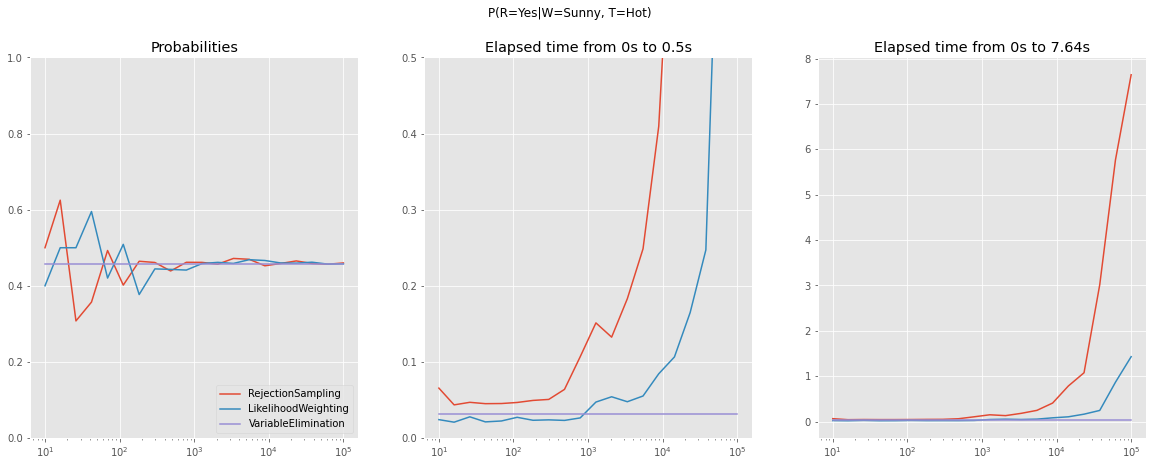

In [ ]:
plot_results(values=res, elapsed_time=total_time, title='P(R=Yes|W=Sunny, T=Hot)')

The second query is: **Query: P(EF=Good|E=Good,WK=No)**.

What is the probability of having good external conditions, knowing that the environment is good as well and the day we are considering is neither the weekend nor holiday.

In [ ]:
# Query: P(EF=Good|E=Good,WK=No)
evidence = [State('Environment','Good'), State('Weekend','No')]
ef_good = State('ExternalFactors','Good')

res, total_time = inference_results(ef_good, evidence)
pd.concat([res, total_time], axis=1)

,SampleSize,RejectionSampling,LikelihoodWeighting,VariableElimination,RS_Time,LW_Time,VE_Time
0,10,0.900000,0.8273,0.8612,0.087411,0.040529,0.019232
1,16,0.937500,0.8210,0.8612,0.046831,0.038206,0.019232
2,26,0.846154,0.8539,0.8612,0.051404,0.023441,0.019232
3,42,0.857143,0.9164,0.8612,0.049297,0.024980,0.019232
4,69,0.840580,0.7414,0.8612,0.162517,0.023471,0.019232
5,112,0.892857,0.8551,0.8612,0.148078,0.104348,0.019232
6,183,0.885246,0.8243,0.8612,0.149328,0.041334,0.019232
7,297,0.818182,0.8385,0.8612,0.220001,0.073598,0.019232
8,483,0.875776,0.9067,0.8612,0.187347,0.084748,0.019232
9,784,0.849490,0.8492,0.8612,0.193333,0.081904,0.019232


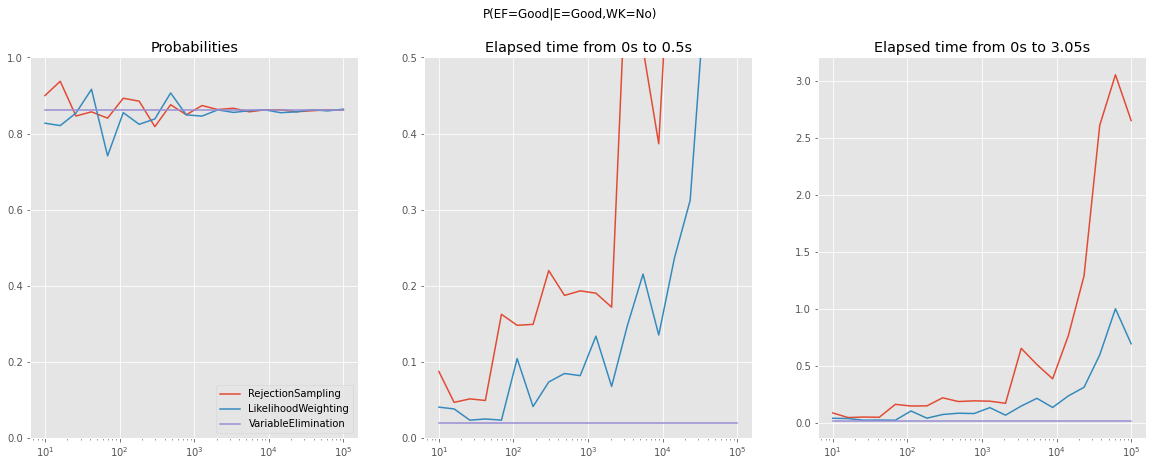

In [ ]:
plot_results(values=res, elapsed_time=total_time, title='P(EF=Good|E=Good,WK=No)')

#### Results analysis considering the two different queries

*   **First graph**: represent the probability distributions and here we can notice that the oscillations of the curves related to Approximate Inference methods, dampen significantly when the number of samples is around 5.000. Consequently, the estimation of the true probability distribution is more accurate.
*   **Second graph**: is a zoomed-in version of the third one, to see how Rejection Sampling and Likelihood Weighting behaves with a low number of samples. Indeed, the latter performs way better than the first one, with a slight difference compared to Variable Elimination.
*   **Third graph**: here, we analyze the overall trend of each curve representing the elapsed time. Rejection Sampling takes a considerable amount of time for computation when we operate with more than 10.000 samples.

### Conclusions
In general Likelihood Weighting shoud be less costly than than Variable Elimination and when it comes to accuracy, we need to increase the number of samples to obtain a satisfactory probablity estimation. Of course the main drawback of this approach is the increasing time of computation.

In the end, it is a trade-off between these two aspects and one could pick the solution right in the middle.